# How to separate touching blobs

The main focus of this article is how to separate touching blobs after they have been succesfully segmented. 

### Problem formulation

The computer vision system has to analyze the dimensions of two different types of connecting rods to allow a vision-guided robot to pick and sort based on their type and dimensions.

Since we are in an **industrial settings**, this task turns out to be pretty easy since we have the control of the light. Having the control of the light is a huge advantage since we can acquire images using techniques that rend rods easily distinguishable (namely much darker) from the background and so we can easily perform a segmentation of the rods.

However, what happens when the rods touch each others? 
Even using the best well known segmentation algorithm (Otsu), we end up in the following situation:

<img src="img/otsu_thresholding_intro.png" width="40%" height="40%">

In this particular case where the rods touch each others we are not able to clearly distinguish each single the rod.

We have the **contraint** that this computer vision system should be able to work **always**, this means without errors. This kind of system is called also *in the industry system*. So we cannot rely on machine learning models to separate these rods since they always have a probability of doing errors. 

So I decide to apply pure computer vision and build a solid and reliable system that is able to succesfully separate the rods when they touch each other.

In the solution I propose in this article has the **assumption** that the rods can have contact points but **do not overlap** one to another.

### Algorithm

I will use python and OpenCV library. <br>
Now let's dive into it.

First of all let's look at the original image.

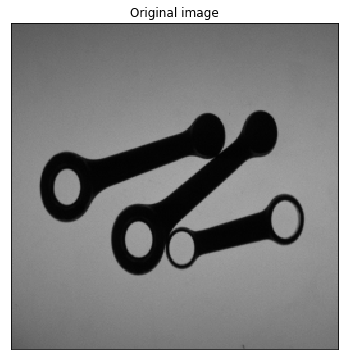

In [11]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(6,6))

original_img = cv.imread('testImages/TESI51.BMP', 0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

We can easily choose manually a theshold to segments the rods. However this is not a good practice and we prefer to rely on an automatic threshold. I decided to use *Otsu's algorithm* that is able to find an automatic threshold under the assumption of a bimodal histogram (which is our case). 

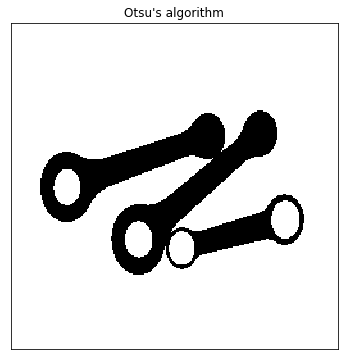

In [12]:
plt.figure(figsize=(6, 6))
ret, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu_img,cmap = 'gray')
plt.title('Otsu\'s algorithm'), plt.xticks([]), plt.yticks([])
plt.show()

This picture is exactly the picture I displayed before.
So how to solve the problem of separating the rods?
One could think that using simple morphology functions like *erosion* or *closing* is enough. Indeed these functions lead into a separation of the rods but they deform the rods structure and we do not want that since the robot has to do accurate measures on these rods. So we want to separate them **without deforming the rods structure**. 

So how to separate them without deforming the rods structure?

The first thing to do was to understand whether in the image there were contact points between rods.
To do so I took several images of rods and then, after segmentation, I calculated the maximum perimeter of a rod (256 pixel) and the minimum perimeter of rods that contact each other (397 pixel) and then I calculated a threshold as $\frac{(256 + 397)}{2} = 326$. So, if a blob has a perimeter greater than or equal than that parameter, it means that there are rods that touch each other.

Afterwards, I noticed that the points I am interested in are points with a *high convexity*. Therefore the idea was to find these points given the contour of the blob (which so far is just one because the rods are touching each other).
So I used the function `convexityDefects` that finds the convexity defects of a contour.
However, not every point that this function returns indicate a contact between rods. So, to select only the interesting points, I decided to count how many white pixels a defect point has in a $5 \times 5$ window around it and check whether there were some evident patterns between defect points that indicate a contact between rods and defect points that do not. <br>
Below I show the plots I obtained of two test images where there are touching rods where the abscissa indicates the defect points whilst the ordinate indicates the sum of white pixels around the defect point in a $5 \times 5$ window:

<img src="img2/defect_points1.png" width="40%" height="40%">
<img src="img2/defect_points2.png" width="40%" height="40%">

Is can be clearly noticed that there are sharp variations between some points. The points that has a low value are indeed the defect points that indicate a contact point between rods.

Now, in order to tell apart these points, I calculated an automatic threshold as follows:
    - consider the defect points values and remove the duplicats
    - order them. Suppose the values we have so far are: [ 510,  765, 3060, 3315]
    - calculate which is the pair of values that shows the maximum variation, in this case 3060 - 765 = 2295.
    - the threshold is computed by dividing by 2 the maximum variation value, so 2295/2 = 1147 would be
      the threshold to select.

Once we know which are the points that indicate a contact between rods, I calculate, for each point, who is its nearest point using the Euclidean distance metric and **draw a white straight line** between them. This lead indeed into a separation between the rods.

The function that computes all the steps I described above is the function I implemented `defect_convexity_algorithm` below.

In [4]:
def defect_convexity_algorithm(imgf):
    
    img, contours, hierarchy = cv.findContours(imgf.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 326: # there are touching elements
            sepc = i
            break
    
    cnt = contours[sepc]
    hull = cv.convexHull(cnt, returnPoints = False)
    defects = cv.convexityDefects(cnt, hull)

    collision_points = []
    
    if sepc != -1: # if sepc is different from "-1", it means that there are touching rods
         for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if (far[0] - 1 >= 0) and (far[1] - 1 >= 0) and (far[0] + 1 <= 255) and (far[1] + 1 <= 255) and (far[0] - 2 >= 0) and (far[1] - 2 >= 0) and (far[0] + 2 <= 255) and (far[1] + 2 <= 255):
                octet_sum = int(img[far[1] - 1, far[0]]) + int(img[far[1] - 1, far[0] - 1]) + int(img[far[1], far[0] - 1]) + int(img[far[1] + 1, far[0] - 1]) + int(img[far[1] + 1, far[0]]) + int(img[far[1] + 1, far[0] + 1]) + int(img[far[1], far[0] + 1]) + int(img[far[1] - 1, far[0] + 1]) + int(img[far[1] - 2, far[0]]) + int(img[far[1] - 2, far[0] - 1]) + int(img[far[1] - 2, far[0] - 2]) + int(img[far[1] -1, far[0] - 2]) + int(img[far[1], far[0] - 2]) + int(img[far[1] + 1, far[0] - 2]) + int(img[far[1] + 2,far[0] - 2]) + int(img[far[1] + 2, far[0] - 1]) + int(img[far[1] + 2, far[0]]) + int(img[far[1] + 2, far[0] + 1]) + int(img[far[1] + 2, far[0] + 2]) + int(img[far[1] + 1, far[0] + 2]) + int(img[far[1], far[0] + 2]) + int(img[far[1] - 1, far[0] + 2]) + int(img[far[1] - 2, far[0] + 2]) + int(img[far[1] - 2, far[0] + 1])
                collision_points.append([far, octet_sum, False])
            
    if len(collision_points) > 0:
        # calculate threshold            
        white_pixel_value_sum = []
        for i in range(len(collision_points)):
            white_pixel_value_sum.append(collision_points[i][1])
        remove_duplicate_list = np.sort(list(set(white_pixel_value_sum)))

        changes_between_values = []
        for i in range(len(remove_duplicate_list) - 1):
            changes_between_values.append(remove_duplicate_list[i + 1] - remove_duplicate_list[i])
        max_change = np.argmax(changes_between_values)
        threshold = int(round((remove_duplicate_list[max_change + 1] + remove_duplicate_list[max_change]) / 2))
    

        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] <= threshold and collision_points[i][2] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean([collision_points[i][0][0], collision_points[i][0][1]], [collision_points[j][0][0], collision_points[j][0][1]])
                    if dst < distance_from_i_to_j and collision_points[j][2] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0],collision_points[i][0][1]),(collision_points[index_of_j][0][0],collision_points[index_of_j][0][1]),(255,0, 0),1)
                collision_points[i][2] = True
                collision_points[index_of_j][2] = True
                
    return img, collision_points

### Algorithm application

Here we apply the algorithm and check how it performs.

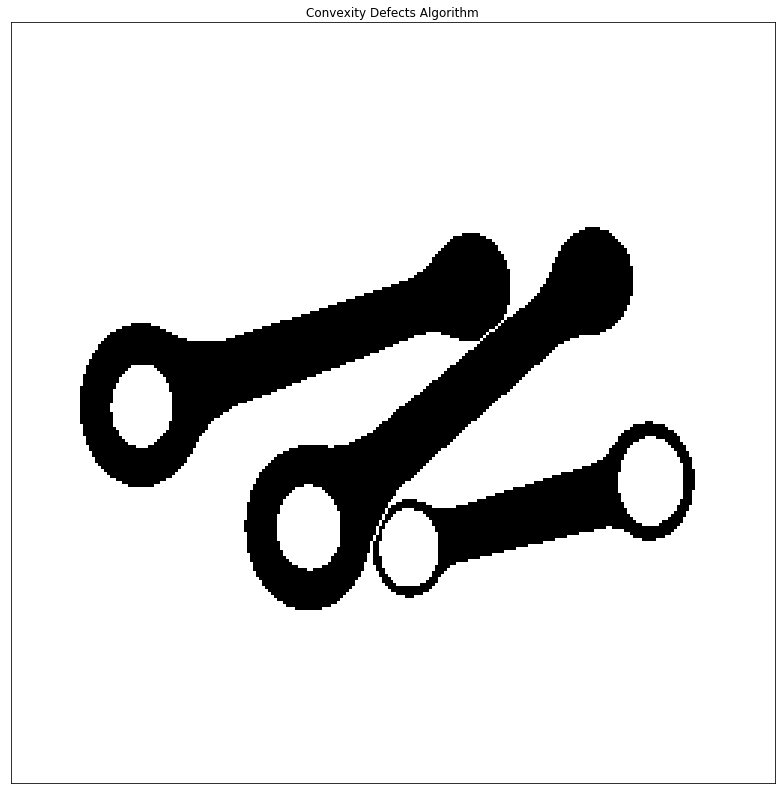

In [5]:
plt.figure(figsize=(14,14))
separate_rods_img, c = defect_convexity_algorithm(otsu_img)
plt.imshow(separate_rods_img,cmap = 'gray')
plt.title('Convexity Defects Algorithm'), plt.xticks([]), plt.yticks([])
plt.show()

As it can be seen, the algorithm succesfully separated the rods without deforming their structure.
Now, we can proceed to analyze each single blob. Below I show as example how to find the position and orientation of each single blob alongside with their barycentre.

### Position orientation and barycentre 

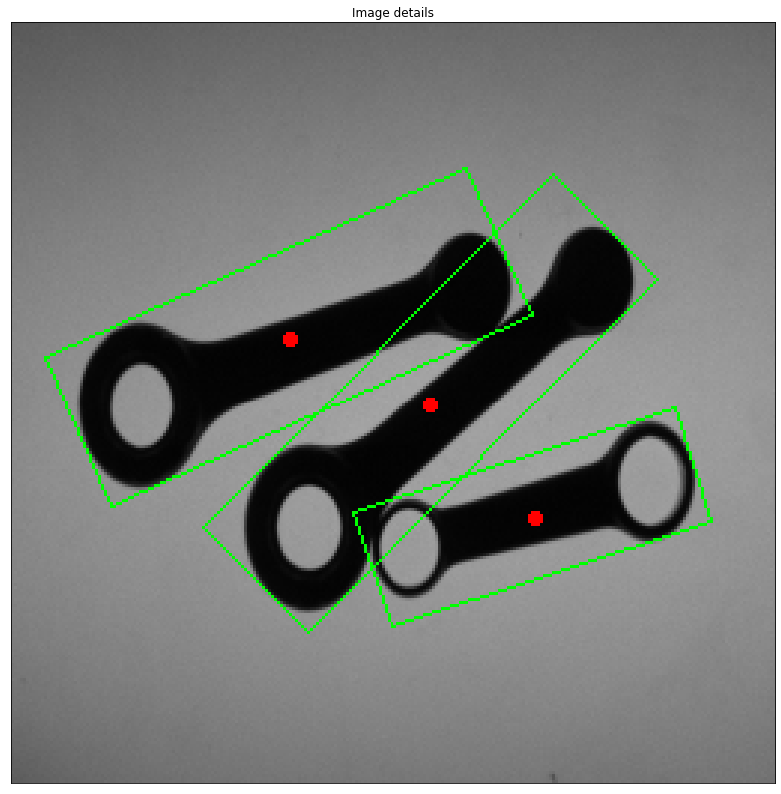

In [9]:
plt.figure(figsize=(14,14))
img, contours, hierarchy = cv.findContours(separate_rods_img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img = original_img.copy()
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        rect = cv.minAreaRect(contours[i])                                             
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0, 255, 0), 1)
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(255, 0, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

### Conclusions

In this article I proposed a solution to separate touching blobs based on pure computer vision algorithms. The algorithm I proposed could be optimized in time and space complexity and tuned in such a way to work with different shapes, not only rods.  